# PG Atlas — A6 Active Subgraph Prototype
## Graph Intelligence for the Stellar Public Goods Ecosystem

**Author:** Jay Gutierrez, PhD | **Date:** February 2026 | **Project:** SCF #41 — Building the Backbone

---

### What This Notebook Does

This notebook builds a **realistic synthetic graph** of the Stellar public goods ecosystem —
modelled precisely on the 86 PG seed projects, 338 submission repos, and dependency topology
revealed by deps.dev — and then runs the core graph intelligence algorithms that will power
PG Atlas v0.

**Algorithms demonstrated:**

| Algorithm | Deliverable | What It Reveals |
|---|---|---|
| Active Subgraph Projection | A6 | Filters dormant repos; the foundation for all scoring |
| Criticality Score (BFS cascade) | A9 | Transitive dependent count — which packages are load-bearing |
| K-Core Decomposition | Extension | Innermost structural skeleton of the ecosystem |
| HHI Pony Factor | A9 | Continuous maintenance concentration risk |
| Bridge Edge Detection | Extension | Single-point-of-failure dependency relationships |
| Funding Efficiency Ratio | Extension | Are critical projects proportionally funded? |

**Synthetic graph mirrors reality:**
- 86 SCF-funded PG projects (real names, real funding amounts)
- ~190 repository nodes (npm, Cargo, PyPI split mirroring Soroban ecosystem)
- ~140 external dependency packages (incl. real hub packages: `@stellar/js-xdr`, `soroban-sdk`)
- ~110 contributor nodes (incl. real prolific contributors from Airtable data)
- Power-law degree distribution (few hubs, many leaves — same as real software ecosystems)
- Realistic activity distribution (67% active, 31% mixed, some dormant — mirrors real data)

---

*This notebook is the prototype foundation for production A6 implementation.*
*All algorithms here will be translated into the `pg_atlas.graph` module once Alex's PostgreSQL schema is locked.*

## 1. Setup & Imports

In [37]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from collections import defaultdict, Counter
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Set
import random
import warnings
import os

warnings.filterwarnings('ignore')

# Reproducible synthetic graph
SEED = 41  # SCF #41
random.seed(SEED)
np.random.seed(SEED)

# Paths
DATA_DIR = os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', '..', '01_data', 'processed')

print("✅ Imports OK")
print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Imports OK
NetworkX version: 3.6.1
NumPy version: 2.4.2
Pandas version: 3.0.1


## 2. Loading Real SCF Data

We load the actual Airtable extracts — 86 PG seed candidates, 78 GitHub orgs, 338 submission repos.
These drive the synthetic graph structure so it accurately mirrors the ecosystem.

In [38]:
# ── Load real SCF project data ──────────────────────────────────────────────
seed_path = os.path.join(DATA_DIR, 'A5_pg_candidate_seed_list.csv')
orgs_path  = os.path.join(DATA_DIR, 'A6_github_orgs_seed.csv')
repos_path = os.path.join(DATA_DIR, 'A7_submission_github_repos.csv')

df_projects = pd.read_csv(seed_path)
df_orgs     = pd.read_csv(orgs_path)
df_repos    = pd.read_csv(repos_path)

# Clean up funding column
df_projects['total_awarded_usd'] = pd.to_numeric(df_projects['total_awarded_usd'], errors='coerce').fillna(0)

print(f"📊 PG Seed Projects:    {len(df_projects):>4} rows")
print(f"📊 GitHub Orgs:         {len(df_orgs):>4} rows")
print(f"📊 Submission Repos:    {len(df_repos):>4} rows")
print()

# Quick ecosystem snapshot
print("── Category Distribution ──────────────────────────────")
for cat, n in df_projects['category'].value_counts().items():
    bar = '█' * n
    print(f"  {cat[:35]:35}  {n:>3}  {bar[:50]}")

print()
print("── Status Distribution ────────────────────────────────")
for status, n in df_projects['integration_status'].value_counts().items():
    pct = n / len(df_projects) * 100
    print(f"  {status:15}  {n:>3}  ({pct:.0f}%)")

print()
funding = df_projects['total_awarded_usd']
print("── Funding Distribution ───────────────────────────────")
print(f"  Total awarded to 86 seeds: ${funding.sum():>12,.0f}")
print(f"  Median:                    ${funding.median():>12,.0f}")
print(f"  Top project (Reflector):   ${funding.max():>12,.0f}")
print(f"  Gini coefficient:          {(funding.sort_values().values * (2*np.arange(1,len(funding)+1) - len(funding) - 1)).sum() / (len(funding) * funding.sum()):.3f}")

📊 PG Seed Projects:      86 rows
📊 GitHub Orgs:           78 rows
📊 Submission Repos:     338 rows

── Category Distribution ──────────────────────────────
  Developer Tooling                     45  █████████████████████████████████████████████
  Infrastructure & Services             41  █████████████████████████████████████████

── Status Distribution ────────────────────────────────
  Mainnet           58  (67%)
  Development       27  (31%)
  Testnet            1  (1%)

── Funding Distribution ───────────────────────────────
  Total awarded to 86 seeds: $   9,179,026
  Median:                    $     100,105
  Top project (Reflector):   $     444,840
  Gini coefficient:          0.365


## 3. Synthetic Graph Construction

The graph mirrors the Stellar ecosystem structure we know from data:

**Node types:**
- `Project` — An SCF-funded public goods project (86 real projects)
- `Repo` — A GitHub repository belonging to a project
- `ExternalRepo` — An npm/PyPI/Cargo package that PG projects depend on
- `Contributor` — A human contributor (developer, maintainer)

**Edge types:**
- `belongs_to` — Repo → Project
- `depends_on` — Repo → Repo/ExternalRepo (dependency relationship)
- `contributed_to` — Contributor → Repo (commit activity)

**Key structural parameters from real data:**
- 86 projects, split 45 Developer Tooling / 41 Infrastructure
- 67% of seed projects at Mainnet (active), 31% in Development, 2% Testnet
- Hub packages: `@stellar/js-xdr` (693 dependents), `@stellar/stellar-base` (463), `soroban-sdk`
- Power-law degree distribution (software ecosystems follow Barabási-Albert dynamics)

In [39]:
# ── Real project roster from Airtable ────────────────────────────────────────

PROJECT_NAMES = df_projects['title'].tolist()
PROJECT_FUNDING = dict(zip(df_projects['title'], df_projects['total_awarded_usd']))
PROJECT_STATUS  = dict(zip(df_projects['title'], df_projects['integration_status']))
PROJECT_CATEGORY = dict(zip(df_projects['title'], df_projects['category']))

# ── Real hub packages (confirmed via deps.dev live calls) ────────────────────
HUB_PACKAGES_NPM = [
    "@stellar/js-xdr",           # 693 dependents — highest in ecosystem
    "@stellar/stellar-base",     # 463 dependents
    "@stellar/stellar-sdk",      # Major SDK
    "@stellar/freighter-api",    # Wallet integration
    "soroban-client",            # Deprecated but still used
    "axios",                     # External dependency
    "eventsource",               # External dependency
]

HUB_PACKAGES_CARGO = [
    "soroban-sdk",               # THE core Soroban crate — blind spot in deps.dev
    "stellar-xdr",               # XDR bindings
    "stellar-strkey",            # Stellar key encoding
    "soroban-env-host",          # Environment host
    "sha2",                      # External crypto dep
    "serde",                     # Universal Rust serialization
    "tokio",                     # Async runtime
]

HUB_PACKAGES_PYPI = [
    "stellar-sdk",               # Python SDK
    "requests",                  # External dep
    "pynacl",                    # Crypto
    "stellar-base",              # Base Python pkg
]

# ── Prolific contributors from Airtable analysis ─────────────────────────────
REAL_CONTRIBUTORS = [
    "christian-rogobete",  # 13 submissions — most prolific
    "ignacio-garcia",      # 8 submissions
    "enzo-soyer",          # 7 submissions
    "esteban-iglesias",    # 7 submissions
    "orbitLens",           # 6 submissions — known ecosystem contributor
    "christos-salaforis",  # 6 submissions
    "alejandro-mujica",
    "dmitri-volkov",
    "wei-zhang",
    "sofia-ramirez",
    "alex-olieman",        # Team member
    "pamphile-roy",        # Team member (SciPy maintainer)
]

# Generate synthetic contributors to fill out the 110-contributor universe
SYNTHETIC_CONTRIBUTORS = [f"dev-{i:03d}" for i in range(1, 99)]
ALL_CONTRIBUTORS = REAL_CONTRIBUTORS + SYNTHETIC_CONTRIBUTORS

print(f"✅ Project roster:      {len(PROJECT_NAMES)} projects")
print(f"✅ Hub packages:        {len(HUB_PACKAGES_NPM + HUB_PACKAGES_CARGO + HUB_PACKAGES_PYPI)} packages")
print(f"✅ Contributor pool:    {len(ALL_CONTRIBUTORS)} contributors")

✅ Project roster:      86 projects
✅ Hub packages:        18 packages
✅ Contributor pool:    110 contributors


In [40]:
# ── Build the multi-layer graph ──────────────────────────────────────────────

G = nx.DiGraph()

# ── LAYER 1: Project nodes ───────────────────────────────────────────────────
for name in PROJECT_NAMES:
    status = PROJECT_STATUS.get(name, 'Development')
    # Map Airtable status → activity probability
    activity_prob = {'Mainnet': 0.90, 'Development': 0.65, 'Testnet': 0.45}.get(status, 0.50)
    # Simulate actual activity (days since last commit)
    if random.random() < activity_prob:
        days_since_commit = max(0, int(np.random.exponential(15)))  # very active
    else:
        days_since_commit = int(np.random.uniform(91, 365))         # dormant

    G.add_node(name,
        node_type='Project',
        category=PROJECT_CATEGORY.get(name, 'Unknown'),
        funding=PROJECT_FUNDING.get(name, 0),
        status=status,
        active=(days_since_commit < 90),
        days_since_commit=days_since_commit,
    )

print(f"Added {sum(1 for n,d in G.nodes(data=True) if d['node_type']=='Project')} Project nodes")

# ── LAYER 2: Repo nodes (2-3 repos per project) ──────────────────────────────
ECOSYSTEMS = ['npm', 'cargo', 'cargo', 'pypi']  # Soroban is Rust-heavy → cargo appears twice
repo_nodes = []

for proj_name in PROJECT_NAMES:
    category = PROJECT_CATEGORY.get(proj_name, '')
    # Infrastructure projects tend to have more repos
    n_repos = np.random.choice([1, 2, 3], p=[0.3, 0.5, 0.2])

    for i in range(n_repos):
        eco = random.choice(ECOSYSTEMS)
        # Infrastructure more likely Cargo; tooling more npm
        if 'Infrastructure' in category:
            eco = random.choice(['cargo', 'cargo', 'npm'])
        else:
            eco = random.choice(['npm', 'npm', 'cargo', 'pypi'])

        repo_id = f"repo:{proj_name.lower().replace(' ', '-').replace('.', '')}-{eco}-{i}"

        # Inherit activity from project with some variance
        proj_active = G.nodes[proj_name]['active']
        proj_days = G.nodes[proj_name]['days_since_commit']
        days_since = max(0, int(proj_days + np.random.normal(0, 10)))

        # Synthetic adoption signals
        is_top = PROJECT_FUNDING.get(proj_name, 0) > 100000
        stars_val = int(np.random.lognormal(mean=5.0 if is_top else 2.5, sigma=1.2))
        forks_val = int(stars_val * random.uniform(0.1, 0.4))
        downloads_val = int(np.random.lognormal(mean=8.0 if is_top else 4.0, sigma=2.0))

        G.add_node(repo_id,
            node_type='Repo',
            ecosystem=eco,
            project=proj_name,
            active=(days_since < 90),
            days_since_commit=days_since,
            latest_commit_date=f"2026-{max(1, min(12, 2 - days_since//30)):02d}-15",
            stars=stars_val,
            forks=forks_val,
            downloads=downloads_val,
        )
        repo_nodes.append(repo_id)
        G.add_edge(repo_id, proj_name, edge_type='belongs_to')

print(f"Added {sum(1 for n,d in G.nodes(data=True) if d['node_type']=='Repo')} Repo nodes")

# ── LAYER 3: External dependency nodes (hub + peripheral) ────────────────────
ext_nodes = []

# Hub packages — always active (maintained by Stellar foundation or major OSS orgs)
for pkg in HUB_PACKAGES_NPM:
    G.add_node(pkg, node_type='ExternalRepo', ecosystem='npm',
               active=True, days_since_commit=random.randint(1, 30), is_hub=True,
               downloads=int(np.random.lognormal(13.0, 1.5)))
    ext_nodes.append(pkg)

for pkg in HUB_PACKAGES_CARGO:
    G.add_node(pkg, node_type='ExternalRepo', ecosystem='cargo',
               active=True, days_since_commit=random.randint(1, 30), is_hub=True,
               downloads=int(np.random.lognormal(11.0, 1.5)))
    ext_nodes.append(pkg)

for pkg in HUB_PACKAGES_PYPI:
    G.add_node(pkg, node_type='ExternalRepo', ecosystem='pypi',
               active=True, days_since_commit=random.randint(1, 30), is_hub=True,
               downloads=int(np.random.lognormal(12.0, 1.5)))
    ext_nodes.append(pkg)

# Peripheral external packages
PERIPHERAL_SUFFIXES = ['utils', 'lib', 'core', 'client', 'helper', 'parser', 'format', 'codec']
for i in range(60):
    eco = random.choice(['npm', 'npm', 'cargo', 'pypi'])
    name = f"ext-{eco}-pkg-{i:03d}"
    active = random.random() < 0.75
    G.add_node(name, node_type='ExternalRepo', ecosystem=eco,
               active=active, days_since_commit=random.randint(1, 200) if not active else random.randint(1, 60),
               is_hub=False,
               downloads=int(np.random.lognormal(6.0, 2.0)))
    ext_nodes.append(name)

print(f"Added {sum(1 for n,d in G.nodes(data=True) if d['node_type']=='ExternalRepo')} ExternalRepo nodes")

Added 86 Project nodes
Added 149 Repo nodes
Added 78 ExternalRepo nodes


In [41]:
# ── LAYER 4: Dependency edges (power-law, hub-biased) ────────────────────────
# Barabási-Albert preferential attachment: new packages preferentially depend on
# already-popular packages. This produces the power-law distribution observed in
# real software ecosystems.

npm_repos   = [r for r in repo_nodes if G.nodes[r]['ecosystem'] == 'npm']
cargo_repos = [r for r in repo_nodes if G.nodes[r]['ecosystem'] == 'cargo']
pypi_repos  = [r for r in repo_nodes if G.nodes[r]['ecosystem'] == 'pypi']

npm_ext   = [p for p in HUB_PACKAGES_NPM] + [n for n in ext_nodes if G.nodes[n]['ecosystem']=='npm']
cargo_ext = [p for p in HUB_PACKAGES_CARGO] + [n for n in ext_nodes if G.nodes[n]['ecosystem']=='cargo']
pypi_ext  = [p for p in HUB_PACKAGES_PYPI] + [n for n in ext_nodes if G.nodes[n]['ecosystem']=='pypi']

dep_edges_added = 0

def add_deps(from_nodes, to_pool, n_direct_range=(1,5), hub_bias=3.0):
    """Add dependency edges with hub-biased preferential attachment."""
    global dep_edges_added
    # Compute weights: hub packages get hub_bias × weight
    weights = np.array([
        hub_bias if G.nodes[t].get('is_hub', False) else 1.0
        for t in to_pool
    ], dtype=float)
    weights /= weights.sum()

    for src in from_nodes:
        n_deps = random.randint(*n_direct_range)
        targets = np.random.choice(to_pool, size=min(n_deps, len(to_pool)),
                                   replace=False, p=weights)
        for tgt in targets:
            if src != tgt and not G.has_edge(src, tgt):
                G.add_edge(src, tgt, edge_type='depends_on', confidence='inferred_shadow')
                dep_edges_added += 1

# npm repos depend on npm packages (including hubs)
add_deps(npm_repos, npm_ext, n_direct_range=(2, 6), hub_bias=4.0)

# Cargo repos depend on Cargo packages (soroban-sdk is THE hub)
add_deps(cargo_repos, cargo_ext, n_direct_range=(2, 5), hub_bias=5.0)

# PyPI repos depend on Python packages
add_deps(pypi_repos, pypi_ext, n_direct_range=(1, 4), hub_bias=3.0)

# Some cross-ecosystem: npm repos sometimes use Cargo via WASM bindings
for repo in random.sample(npm_repos, k=len(npm_repos)//4):
    wasm_target = random.choice(cargo_ext[:3])  # soroban-sdk, stellar-xdr, stellar-strkey
    if not G.has_edge(repo, wasm_target):
        G.add_edge(repo, wasm_target, edge_type='depends_on', confidence='inferred_shadow')
        dep_edges_added += 1

print(f"Added {dep_edges_added} dependency edges")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Added 502 dependency edges
Total nodes: 313
Total edges: 651


In [42]:
# ── LAYER 5: Contributor nodes and contributed_to edges ──────────────────────

# Add contributor nodes
for contrib in ALL_CONTRIBUTORS:
    is_prolific = contrib in REAL_CONTRIBUTORS
    G.add_node(contrib,
        node_type='Contributor',
        is_prolific=is_prolific,
        # Prolific contributors are active; synthetic ones vary
        active=True if is_prolific else random.random() < 0.7,
    )

# Assign contributors to repos realistically:
# - Prolific real contributors: active in 3-8 repos (often cross-project)
# - Regular contributors: 1-3 repos
# - Pony factor: some repos will be dominated by 1 contributor

contrib_edges_added = 0
repo_contributors = defaultdict(list)  # repo → list of (contributor, commit_count)

for repo in repo_nodes:
    proj = G.nodes[repo]['project']

    # Primary contributor: always 1 (the lead maintainer)
    # Draw from real contributors for funded projects, synthetic for others
    is_top_project = PROJECT_FUNDING.get(proj, 0) > 150000

    if is_top_project and REAL_CONTRIBUTORS:
        primary = random.choice(REAL_CONTRIBUTORS[:6])  # top 6 prolific contributors
    else:
        primary = random.choice(ALL_CONTRIBUTORS)

    # Commit distribution for primary contributor
    # Some repos are pony-factor (single contributor > 50%)
    pony_risk = random.random() < 0.35  # 35% of repos have pony factor risk

    if pony_risk:
        primary_share = random.uniform(0.55, 0.92)
    else:
        primary_share = random.uniform(0.20, 0.49)

    total_commits = random.randint(30, 500)
    primary_commits = int(total_commits * primary_share)

    repo_contributors[repo].append((primary, primary_commits))
    G.add_edge(primary, repo, 
               edge_type='contributed_to',
               commits=primary_commits,
               last_commit_days=G.nodes[repo]['days_since_commit'])
    contrib_edges_added += 1

    # Secondary contributors
    n_secondary = random.randint(0, 4) if not pony_risk else random.randint(0, 2)
    remaining_commits = total_commits - primary_commits

    available = [c for c in ALL_CONTRIBUTORS if c != primary]
    secondary_pool = random.sample(available, k=min(n_secondary, len(available)))

    for sc in secondary_pool:
        sc_commits = max(1, int(remaining_commits / max(1, n_secondary) * random.uniform(0.5, 1.5)))
        repo_contributors[repo].append((sc, sc_commits))
        G.add_edge(sc, repo,
                   edge_type='contributed_to',
                   commits=sc_commits,
                   last_commit_days=G.nodes[repo]['days_since_commit'] + random.randint(0, 20))
        contrib_edges_added += 1

print(f"Added {sum(1 for n,d in G.nodes(data=True) if d['node_type']=='Contributor')} Contributor nodes")
print(f"Added {contrib_edges_added} contributed_to edges")
print()
print(f"╔══════════════════════════════════════════════════════╗")
print(f"║  GRAPH SUMMARY                                       ║")
print(f"╠══════════════════════════════════════════════════════╣")
for nt in ['Project', 'Repo', 'ExternalRepo', 'Contributor']:
    n = sum(1 for _,d in G.nodes(data=True) if d.get('node_type')==nt)
    print(f"║  {nt:15} nodes:  {n:>4}                         ║")
print(f"╠══════════════════════════════════════════════════════╣")
for et in ['belongs_to', 'depends_on', 'contributed_to']:
    n = sum(1 for _,_,d in G.edges(data=True) if d.get('edge_type')==et)
    print(f"║  {et:20} edges: {n:>4}                      ║")
print(f"╚══════════════════════════════════════════════════════╝")

Added 110 Contributor nodes
Added 399 contributed_to edges

╔══════════════════════════════════════════════════════╗
║  GRAPH SUMMARY                                       ║
╠══════════════════════════════════════════════════════╣
║  Project         nodes:    86                         ║
║  Repo            nodes:   149                         ║
║  ExternalRepo    nodes:    78                         ║
║  Contributor     nodes:   110                         ║
╠══════════════════════════════════════════════════════╣
║  belongs_to           edges:  149                      ║
║  depends_on           edges:  502                      ║
║  contributed_to       edges:  399                      ║
╚══════════════════════════════════════════════════════╝


## 4. Active Subgraph Projection (A6)

**This is the A6 algorithm** — the first step in all PG Atlas scoring.

The raw dependency graph contains dormant repos: projects that received SCF funding but 
have since gone quiet. Including them in criticality scoring would inflate scores for 
packages they depend on (even though those packages no longer serve active downstream users).

The active subgraph projection:
1. Classifies each repo node as `active` or `dormant` based on activity signals
2. Retains only active nodes in the induced subgraph
3. Rebuilds the dependency edges to connect only active-to-active nodes

**Activity criteria (mirroring the proposal spec):**
- `active` = last commit within 90 days AND repository not archived

This projection is the prerequisite for every downstream metric. It must run first,
and must be updated on each ingestion cycle.

In [43]:
# ── A6: Active Subgraph Projection ───────────────────────────────────────────

def active_subgraph_projection(G: nx.DiGraph, 
                                active_window_days: int = 90) -> nx.DiGraph:
    """
    Project the dependency graph onto active nodes only.

    Args:
        G: Full multi-layer directed graph
        active_window_days: Repos with last commit > this many days ago are dormant

    Returns:
        G_active: Induced subgraph over active Repo and ExternalRepo nodes,
                  preserving all Project and Contributor nodes.

    Complexity: O(V + E)
    """
    # Step 1: Classify nodes
    active_nodes = set()
    dormant_nodes = set()

    for node, data in G.nodes(data=True):
        node_type = data.get('node_type', '')

        if node_type in ('Project', 'Contributor'):
            # Project and Contributor nodes are always retained
            active_nodes.add(node)
        elif node_type in ('Repo', 'ExternalRepo'):
            days = data.get('days_since_commit', 999)
            archived = data.get('archived', False)
            if days <= active_window_days and not archived:
                active_nodes.add(node)
            else:
                dormant_nodes.add(node)

    # Step 2: Build induced subgraph
    G_active = G.subgraph(active_nodes).copy()

    # Step 3: Annotate retained/removed counts on graph for audit
    G_active.graph['active_window_days'] = active_window_days
    G_active.graph['nodes_retained'] = len(active_nodes)
    G_active.graph['nodes_removed'] = len(dormant_nodes)
    G_active.graph['dormant_nodes'] = list(dormant_nodes)

    return G_active, dormant_nodes


# ── Run the projection ────────────────────────────────────────────────────────
G_active, dormant = active_subgraph_projection(G, active_window_days=90)

total_repos = sum(1 for n,d in G.nodes(data=True) if d.get('node_type') in ('Repo','ExternalRepo'))
active_repos = sum(1 for n,d in G_active.nodes(data=True) if d.get('node_type') in ('Repo','ExternalRepo'))
dormant_count = len(dormant)

print("╔══════════════════════════════════════════════════════════════╗")
print("║  A6: ACTIVE SUBGRAPH PROJECTION RESULTS                     ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  Full graph nodes:          {G.number_of_nodes():>5}                        ║")
print(f"║  Active subgraph nodes:     {G_active.number_of_nodes():>5}  ({G_active.number_of_nodes()/G.number_of_nodes()*100:.1f}% retained)         ║")
print(f"║  Dormant nodes pruned:      {dormant_count:>5}  ({dormant_count/G.number_of_nodes()*100:.1f}% removed)          ║")
print(f"║                                                              ║")
print(f"║  Full graph edges:          {G.number_of_edges():>5}                        ║")
print(f"║  Active subgraph edges:     {G_active.number_of_edges():>5}  ({G_active.number_of_edges()/G.number_of_edges()*100:.1f}% retained)         ║")
print("╚══════════════════════════════════════════════════════════════╝")
print()

# Show some dormant projects (ecosystem insight)
dormant_projects = [n for n in dormant if G.nodes[n].get('node_type') == 'Repo']
print(f"⚠️  Sample of dormant repos (first 8):")
for repo in list(dormant_projects)[:8]:
    proj = G.nodes[repo].get('project', 'unknown')
    days = G.nodes[repo].get('days_since_commit', 0)
    funding = PROJECT_FUNDING.get(proj, 0)
    print(f"   {repo[:45]:45}  {days:>3} days since commit  (${funding:>8,.0f} funded)")

╔══════════════════════════════════════════════════════════════╗
║  A6: ACTIVE SUBGRAPH PROJECTION RESULTS                     ║
╠══════════════════════════════════════════════════════════════╣
║  Full graph nodes:            423                        ║
║  Active subgraph nodes:       383  (90.5% retained)         ║
║  Dormant nodes pruned:         40  (9.5% removed)          ║
║                                                              ║
║  Full graph edges:           1050                        ║
║  Active subgraph edges:       851  (81.0% retained)         ║
╚══════════════════════════════════════════════════════════════╝

⚠️  Sample of dormant repos (first 8):
   repo:scout-pypi-1                              113 days since commit  ($ 240,000 funded)
   repo:solang-playground-npm-1                   209 days since commit  ($  42,000 funded)
   repo:transfuse:-multichain-asset-bridge-npm-0  248 days since commit  ($  30,000 funded)
   repo:flashback-npm-2                        

## 5. Criticality Score — Transitive Active Dependents (A9)

**The flagship metric.** A package is critical not because many things directly depend on it,
but because many active packages *transitively* depend on it — and removing it would cascade.

**Algorithm:** BFS on the reversed dependency graph from each active leaf node.

The key insight is directionality: the dependency graph has edges pointing *toward* dependencies
(A → B means "A depends on B"). To count dependents, we reverse the graph and run BFS from each
package — the set of nodes reachable from package P in the reversed graph is exactly the set of
packages that (transitively) depend on P.

This is the software-ecosystem equivalent of trophic cascade modeling:
removing a keystone package cascades the same way removing a keystone species collapses
a food web.

In [44]:
# ── Criticality Score: BFS on reversed dependency graph ──────────────────────

def compute_criticality_scores(G_active: nx.DiGraph) -> Dict[str, int]:
    """
    Compute transitive active dependent count for every Repo and ExternalRepo node.

    Algorithm:
        1. Build reversed dependency subgraph (only depends_on edges)
        2. Identify active leaf nodes (nodes with no active dependents = entry points)
        3. For each package P, count reachable nodes in G_reversed from P
           (these are all packages that transitively depend on P)

    Returns:
        Dict mapping node_id → criticality_score (int)

    Complexity: O(V × (V + E)) worst case; practical performance is much faster
    due to power-law degree distribution (most nodes are leaves).
    """
    # Extract dependency subgraph (only depends_on edges, only Repo/ExternalRepo nodes)
    dep_nodes = {n for n, d in G_active.nodes(data=True) 
                 if d.get('node_type') in ('Repo', 'ExternalRepo')}

    dep_edges = [(u, v) for u, v, d in G_active.edges(data=True) 
                 if d.get('edge_type') == 'depends_on' 
                 and u in dep_nodes and v in dep_nodes]

    G_dep = nx.DiGraph()
    G_dep.add_nodes_from(dep_nodes)
    G_dep.add_edges_from(dep_edges)

    # Reverse: edges now point FROM depended-upon TO dependent
    G_rev = G_dep.reverse(copy=True)

    criticality = {}
    for node in dep_nodes:
        # nx.descendants returns all nodes reachable in the reversed graph
        # = all packages that transitively depend on 'node'
        transitive_dependents = nx.descendants(G_rev, node)
        # Only count active nodes
        active_dependents = {n for n in transitive_dependents 
                             if G_active.nodes[n].get('active', False)}
        criticality[node] = len(active_dependents)

    return criticality


# ── Temporal-decay weighted criticality (Tier 2 extension) ───────────────────

def compute_decay_criticality(G_active: nx.DiGraph, 
                               base_criticality: Dict[str, int],
                               decay_halflife_days: float = 30.0) -> Dict[str, float]:
    """
    Weighted criticality: each transitive dependent contributes exp(-days/halflife).
    A dependent that committed yesterday = weight 1.0
    A dependent that committed 90 days ago = weight exp(-3) ≈ 0.05
    """
    dep_nodes = {n for n, d in G_active.nodes(data=True) 
                 if d.get('node_type') in ('Repo', 'ExternalRepo')}

    dep_edges = [(u, v) for u, v, d in G_active.edges(data=True) 
                 if d.get('edge_type') == 'depends_on' 
                 and u in dep_nodes and v in dep_nodes]

    G_dep = nx.DiGraph()
    G_dep.add_nodes_from(dep_nodes)
    G_dep.add_edges_from(dep_edges)
    G_rev = G_dep.reverse(copy=True)

    decay_criticality = {}
    for node in dep_nodes:
        transitive_dependents = nx.descendants(G_rev, node)
        active_dependents = {n for n in transitive_dependents 
                             if G_active.nodes[n].get('active', False)}
        score = sum(
            np.exp(-G_active.nodes[n].get('days_since_commit', 0) / decay_halflife_days)
            for n in active_dependents
        )
        decay_criticality[node] = round(score, 3)

    return decay_criticality


# ── Run both ──────────────────────────────────────────────────────────────────
print("Computing criticality scores (BFS on reversed dependency graph)...")
criticality_scores = compute_criticality_scores(G_active)
decay_scores = compute_decay_criticality(G_active, criticality_scores)
print("✅ Done")

# ── Top 20 most critical packages ─────────────────────────────────────────────
sorted_crit = sorted(criticality_scores.items(), key=lambda x: x[1], reverse=True)
all_scores  = np.array([v for v in criticality_scores.values()])
percentiles = {node: int(np.searchsorted(np.sort(all_scores), score) / len(all_scores) * 100)
               for node, score in criticality_scores.items()}

print()
print("╔══════════════════════════════════════════════════════════════════════╗")
print("║  TOP 20 MOST CRITICAL PACKAGES (by transitive active dependents)    ║")
print("╠══════════════════════════════════════════════════════════════════════╣")
print(f"  {'Package':<40} {'Eco':>5}  {'Score':>6}  {'%ile':>5}  {'DecayWt':>8}")
print(f"  {'─'*40} {'─'*5}  {'─'*6}  {'─'*5}  {'─'*8}")
for node, score in sorted_crit[:20]:
    eco = G_active.nodes[node].get('ecosystem', '?')[:5]
    pct = percentiles[node]
    dscore = decay_scores.get(node, 0)
    bar = '▓' * min(20, score)
    print(f"  {node[:40]:<40} {eco:>5}  {score:>6}  {pct:>4}%  {dscore:>8.2f}")

print("╚══════════════════════════════════════════════════════════════════════╝")

Computing criticality scores (BFS on reversed dependency graph)...
✅ Done

╔══════════════════════════════════════════════════════════════════════╗
║  TOP 20 MOST CRITICAL PACKAGES (by transitive active dependents)    ║
╠══════════════════════════════════════════════════════════════════════╣
  Package                                    Eco   Score   %ile   DecayWt
  ──────────────────────────────────────── ─────  ──────  ─────  ────────
  stellar-strkey                           cargo      27    99%     17.60
  tokio                                    cargo      24    98%     16.61
  serde                                    cargo      23    98%     15.78
  sha2                                     cargo      22    97%     14.97
  soroban-sdk                              cargo      22    97%     16.55
  stellar-xdr                              cargo      21    96%     15.64
  @stellar/js-xdr                            npm      20    95%     13.89
  soroban-env-host                       

## 6. K-Core Decomposition — The Structural Skeleton

K-core decomposition reveals the nested shell structure of the dependency graph.
The k-core is the maximal subgraph where every node has at least k connections to 
other nodes in the subgraph. Higher k = more deeply embedded in mutual dependencies.

**Why this matters for PG Atlas:**
The innermost core (highest k) contains the packages most deeply woven into the ecosystem —
the ones that are both depended-upon AND depend on other core packages. These are the
structural foundations that the entire ecosystem rests on.

In ecological terms: these are the keystone species of the Stellar developer ecosystem.

*Note: K-core decomposition requires an undirected graph (mutual relationships).
We use the undirected version of the dependency subgraph here.*

In [45]:
# ── K-Core Decomposition ──────────────────────────────────────────────────────

def kcore_analysis(G_active: nx.DiGraph) -> Tuple[nx.Graph, Dict[str, int]]:
    """
    Compute k-core decomposition of the active dependency graph.

    Returns:
        G_undirected: Undirected version of dependency subgraph
        core_numbers: Dict mapping node → k-core number
    """
    # Extract dependency subgraph (Repo + ExternalRepo only)
    dep_nodes = {n for n, d in G_active.nodes(data=True) 
                 if d.get('node_type') in ('Repo', 'ExternalRepo')}

    dep_edges = [(u, v) for u, v, d in G_active.edges(data=True) 
                 if d.get('edge_type') == 'depends_on' 
                 and u in dep_nodes and v in dep_nodes]

    G_undirected = nx.Graph()
    G_undirected.add_nodes_from(dep_nodes)
    G_undirected.add_edges_from(dep_edges)

    # Copy node attributes
    for n in dep_nodes:
        G_undirected.nodes[n].update(G_active.nodes[n])

    core_numbers = nx.core_number(G_undirected)

    return G_undirected, core_numbers


G_undirected, core_numbers = kcore_analysis(G_active)
max_core = max(core_numbers.values()) if core_numbers else 0

# Assign core numbers back to main graph
for node, core_k in core_numbers.items():
    if node in G_active.nodes:
        G_active.nodes[node]['core_number'] = core_k

# Core shell analysis
from collections import Counter
core_dist = Counter(core_numbers.values())

print("╔══════════════════════════════════════════════════════════════╗")
print("║  K-CORE DECOMPOSITION RESULTS                                ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  Maximum core number: k = {max_core:<5}                            ║")
print(f"║  Nodes in graph:          {len(core_numbers):<5}                            ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"  {'K-Core':>8}   {'# Nodes':>8}   Packages in this shell")
print(f"  {'─'*8}   {'─'*8}   {'─'*40}")

for k in sorted(core_dist.keys(), reverse=True):
    nodes_at_k = [n for n, c in core_numbers.items() if c == k]
    n_nodes = core_dist[k]
    sample = ', '.join(n[:25] for n in nodes_at_k[:3])
    marker = " ◄── INNER CORE" if k == max_core else (" ◄── CRITICAL" if k >= max_core * 0.7 else "")
    print(f"  k = {k:>4}   {n_nodes:>8}   {sample[:50]}{marker}")

print()
print("🔑 INNER CORE (highest k) — the structural skeleton:")
inner_core_nodes = [n for n, k in core_numbers.items() if k == max_core]
for node in inner_core_nodes:
    eco = G_active.nodes[node].get('ecosystem', '?')
    crit = criticality_scores.get(node, 0)
    pct = percentiles.get(node, 0)
    print(f"   {node[:50]:<50}  eco={eco:<6}  criticality={crit:>4} ({pct:>2}%ile)")

╔══════════════════════════════════════════════════════════════╗
║  K-CORE DECOMPOSITION RESULTS                                ║
╠══════════════════════════════════════════════════════════════╣
║  Maximum core number: k = 4                                ║
║  Nodes in graph:          187                              ║
╠══════════════════════════════════════════════════════════════╣
    K-Core    # Nodes   Packages in this shell
  ────────   ────────   ────────────────────────────────────────
  k =    4         40   repo:lightecho-stellar-or, @stellar/js-xdr, ext-ca ◄── INNER CORE
  k =    3         51   repo:onboard-game-devs-wi, repo:0xauth-cargo-0, re ◄── CRITICAL
  k =    2         72   repo:satellite-+-we-work-, repo:gatewayfm-cargo-0,
  k =    1         16   repo:subs-cargo-1, repo:soroban-sdk-tools-py, ext-
  k =    0          8   ext-npm-pkg-047, ext-npm-pkg-024, ext-npm-pkg-023

🔑 INNER CORE (highest k) — the structural skeleton:
   repo:lightecho-stellar-oracle-cargo-1       

## 7. Pony Factor — Maintenance Concentration Risk (A9)

The pony factor measures how concentrated a project's maintenance is in a single contributor.
If one person accounts for the majority of commits, the project is at risk: if they disappear,
maintenance stops.

**Two implementations:**

1. **Binary Pony Factor (proposal requirement):** Flag = 1 if any contributor accounts for ≥50% of commits
2. **HHI Pony Factor (Tier 2 extension):** Herfindahl-Hirschman Index over contributor commit shares — a continuous score that distinguishes 51% concentration from 92% concentration

HHI is borrowed from economics (market concentration analysis, where it's used to detect monopolies).
In portfolio management, it measures asset concentration. Here it measures contribution concentration.

`HHI = Σ(commit_share_i²) × 10,000`

Risk tiers: HHI < 1,500 = healthy | 1,500–2,500 = moderate | > 2,500 = concentrated | 10,000 = single contributor

In [46]:
# ── Pony Factor Computation ───────────────────────────────────────────────────

@dataclass
class PonyFactorResult:
    repo: str
    pony_factor: int          # Binary: 1 = at risk
    hhi: float                # Continuous HHI (0–10,000)
    top_contributor: str
    top_contributor_share: float
    total_contributors: int
    total_commits: int
    risk_tier: str            # 'healthy' | 'moderate' | 'concentrated' | 'critical'

def compute_pony_factors(G_active: nx.DiGraph) -> Dict[str, PonyFactorResult]:
    """
    Compute binary and HHI pony factor for every Repo node in the active subgraph.

    Uses the contributed_to edges and their 'commits' attribute.
    """
    results = {}

    repo_nodes = [n for n, d in G_active.nodes(data=True) if d.get('node_type') == 'Repo']

    for repo in repo_nodes:
        # Get all contributors to this repo
        contributors = [
            (u, d['commits'])
            for u, v, d in G_active.in_edges(repo, data=True)
            if d.get('edge_type') == 'contributed_to' and 'commits' in d
        ]

        if not contributors:
            continue

        total_commits = sum(c for _, c in contributors)
        if total_commits == 0:
            continue

        shares = [(contrib, commits / total_commits) for contrib, commits in contributors]
        shares.sort(key=lambda x: x[1], reverse=True)

        top_contrib, top_share = shares[0]

        # Binary pony factor
        pony_flag = 1 if top_share >= 0.50 else 0

        # HHI: sum of squared shares × 10,000
        hhi = sum(s**2 for _, s in shares) * 10_000

        # Risk tier
        if hhi < 1500:
            risk_tier = 'healthy'
        elif hhi < 2500:
            risk_tier = 'moderate'
        elif hhi < 5000:
            risk_tier = 'concentrated'
        else:
            risk_tier = 'critical'

        results[repo] = PonyFactorResult(
            repo=repo,
            pony_factor=pony_flag,
            hhi=round(hhi, 1),
            top_contributor=top_contrib,
            top_contributor_share=round(top_share, 3),
            total_contributors=len(contributors),
            total_commits=total_commits,
            risk_tier=risk_tier,
        )

    return results


pony_results = compute_pony_factors(G_active)

# Summary
pony_flagged = sum(1 for r in pony_results.values() if r.pony_factor == 1)
risk_dist    = Counter(r.risk_tier for r in pony_results.values())
total_repos_with_pf = len(pony_results)

print("╔══════════════════════════════════════════════════════════════╗")
print("║  PONY FACTOR ANALYSIS                                        ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  Repos analyzed:              {total_repos_with_pf:>5}                        ║")
print(f"║  Repos with pony factor=1:    {pony_flagged:>5}  ({pony_flagged/total_repos_with_pf*100:.0f}% of repos)       ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"  {'Risk Tier':15}  {'Count':>6}  {'%':>5}  Description")
print(f"  {'─'*15}  {'─'*6}  {'─'*5}  {'─'*35}")
tier_desc = {
    'healthy': 'HHI < 1,500 — well-distributed contributions',
    'moderate': 'HHI 1,500–2,500 — some concentration',
    'concentrated': 'HHI 2,500–5,000 — high concentration risk',
    'critical': 'HHI > 5,000 — near-single-contributor risk',
}
for tier in ['healthy', 'moderate', 'concentrated', 'critical']:
    n = risk_dist.get(tier, 0)
    pct = n / total_repos_with_pf * 100 if total_repos_with_pf else 0
    print(f"  {tier:15}  {n:>6}  {pct:>4.0f}%  {tier_desc[tier]}")

print()
print("⚠️  TOP 10 HIGHEST-RISK REPOS (sorted by HHI):")
top_risk = sorted(pony_results.values(), key=lambda r: r.hhi, reverse=True)[:10]
print(f"  {'Repo':<35} {'HHI':>7}  {'Top Contributor':<25} {'Share':>6}  {'Tier'}")
print(f"  {'─'*35} {'─'*7}  {'─'*25} {'─'*6}  {'─'*12}")
for r in top_risk:
    proj = G_active.nodes[r.repo].get('project', '')[:15]
    print(f"  {r.repo[:35]:<35} {r.hhi:>7.0f}  {r.top_contributor[:25]:<25} {r.top_contributor_share:>5.0%}  {r.risk_tier}")

╔══════════════════════════════════════════════════════════════╗
║  PONY FACTOR ANALYSIS                                        ║
╠══════════════════════════════════════════════════════════════╣
║  Repos analyzed:                123                        ║
║  Repos with pony factor=1:       78  (63% of repos)       ║
╠══════════════════════════════════════════════════════════════╣
  Risk Tier         Count      %  Description
  ───────────────  ──────  ─────  ───────────────────────────────────
  healthy               0     0%  HHI < 1,500 — well-distributed contributions
  moderate             11     9%  HHI 1,500–2,500 — some concentration
  concentrated         44    36%  HHI 2,500–5,000 — high concentration risk
  critical             68    55%  HHI > 5,000 — near-single-contributor risk

⚠️  TOP 10 HIGHEST-RISK REPOS (sorted by HHI):
  Repo                                    HHI  Top Contributor            Share  Tier
  ─────────────────────────────────── ───────  ───────────────

## 8. Adoption Signals (A10)

Adoption signals (stars, forks, downloads) proxy the relevance of a package. We take the raw signals, apply log-scale normalization ($log_{10}(1 + x)$), and compute percentile ranks to produce a composite **Adoption Score** (0–100 percentile).

In [47]:
# ── Adoption Signals (A10) ────────────────────────────────────────────────────

adoption_records = []
for node, data in G_active.nodes(data=True):
    if data.get('node_type') in ('Repo', 'ExternalRepo'):
        # Extract signals
        stars = data.get('stars', 0)
        forks = data.get('forks', 0)
        downloads = data.get('downloads', 0)

        # Log-scale normalization: log10(1 + x)
        log_stars = np.log10(1 + stars)
        log_forks = np.log10(1 + forks)
        log_downloads = np.log10(1 + downloads)

        adoption_records.append({
            'node': node,
            'node_type': data.get('node_type'),
            'stars': stars,
            'forks': forks,
            'downloads': downloads,
            'log_stars': log_stars,
            'log_forks': log_forks,
            'log_downloads': log_downloads
        })

df_adopt = pd.DataFrame(adoption_records)

# Compute percentile ranks for log-scaled values
df_adopt['stars_pct'] = df_adopt['log_stars'].rank(pct=True) * 100
df_adopt['forks_pct'] = df_adopt['log_forks'].rank(pct=True) * 100
df_adopt['downloads_pct'] = df_adopt['log_downloads'].rank(pct=True) * 100

# Composite adoption score (average of percentiles)
df_adopt['adoption_score'] = df_adopt[['stars_pct', 'forks_pct', 'downloads_pct']].mean(axis=1)

# Map back to graph
adoption_scores = dict(zip(df_adopt['node'], df_adopt['adoption_score']))
for node, score in adoption_scores.items():
    if node in G_active.nodes:
        G_active.nodes[node]['adoption_score'] = score

print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║  TOP 15 MOST ADOPTED PACKAGES (Composite Score)                              ║")
print("╠══════════════════════════════════════════════════════════════════════════════╣")
print(f"  {'Package':<40} {'Type':>10}  {'Adoption':>8}  {'Stars':>6}  {'Forks':>6}  {'Downloads':>9}")
print(f"  {'─'*40} {'─'*10}  {'─'*8}  {'─'*6}  {'─'*6}  {'─'*9}")

top_adopted = df_adopt.sort_values('adoption_score', ascending=False).head(15)
for _, row in top_adopted.iterrows():
    print(f"  {row['node'][:40]:<40} {row['node_type']:>10}  {row['adoption_score']:>7.1f}%  {row['stars']:>6.0f}  {row['forks']:>6.0f}  {row['downloads']:>9,.0f}")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════════════════════════════════╗
║  TOP 15 MOST ADOPTED PACKAGES (Composite Score)                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
  Package                                        Type  Adoption   Stars   Forks  Downloads
  ──────────────────────────────────────── ──────────  ────────  ──────  ──────  ─────────
  repo:agnostic-cargo-1                          Repo     94.3%     876     133     20,649
  repo:bpv-stellarmesh-anchor-npm-0              Repo     93.6%     560     154     19,116
  repo:loam-npm-1                                Repo     92.9%     545     202     10,939
  repo:tansu---soroban-versioning-npm-1          Repo     92.0%     434      77     25,993
  repo:bpv-stellarmesh-anchor-cargo-1            Repo     89.8%     211      71     39,928
  repo:communidao-npm-0                          Repo     89.1%     275      76     13,399
  repo:humantech-cargo-1     

## 9. Bridge Edge Detection — Single Points of Structural Failure

A **bridge** is an edge whose removal would disconnect two previously connected components
of the graph. In the dependency context: a bridge dependency is a relationship where
Package A is the *only* way that one part of the ecosystem connects to another.

If the package at one end of a bridge is deprecated or abandoned, the other end loses
its connection to the rest of the dependency network — a structural fracture, not just
a package absence.

Bridge detection uses Tarjan's algorithm (O(V + E)) on the undirected dependency graph.

In [48]:
# ── Bridge Edge Detection ─────────────────────────────────────────────────────

def find_bridge_edges(G_active: nx.DiGraph) -> List[Tuple[str, str]]:
    """
    Find bridge edges in the active dependency subgraph.

    A bridge edge is one whose removal disconnects the graph.
    These represent single-point-of-failure dependency relationships.

    Returns list of (u, v) edge tuples that are bridges.
    """
    # Build undirected dependency subgraph
    dep_nodes = {n for n, d in G_active.nodes(data=True) 
                 if d.get('node_type') in ('Repo', 'ExternalRepo')}

    dep_edges = [(u, v) for u, v, d in G_active.edges(data=True) 
                 if d.get('edge_type') == 'depends_on' 
                 and u in dep_nodes and v in dep_nodes]

    G_u = nx.Graph()
    G_u.add_nodes_from(dep_nodes)
    G_u.add_edges_from(dep_edges)

    bridges = list(nx.bridges(G_u))
    return bridges


bridges = find_bridge_edges(G_active)

print(f"╔══════════════════════════════════════════════════════════════╗")
print(f"║  BRIDGE EDGE ANALYSIS                                        ║")
print(f"╠══════════════════════════════════════════════════════════════╣")
print(f"║  Total dependency edges in active graph: {sum(1 for _,_,d in G_active.edges(data=True) if d.get('edge_type')=='depends_on'):>5}               ║")
print(f"║  Bridge edges detected:                  {len(bridges):>5}               ║")
pct_bridges = len(bridges) / max(1, sum(1 for _,_,d in G_active.edges(data=True) if d.get('edge_type')=='depends_on')) * 100
print(f"║  Bridge edges as % of dependency edges:  {pct_bridges:>4.1f}%               ║")
print(f"╚══════════════════════════════════════════════════════════════╝")

if bridges:
    print()
    print(f"⚡ Sample bridge edges (structural single-points-of-failure):")
    for u, v in bridges[:8]:
        u_type = G_active.nodes.get(u, {}).get('node_type', '?')
        v_type = G_active.nodes.get(v, {}).get('node_type', '?')
        print(f"   {u[:35]:35} ──► {v[:35]:35}")

╔══════════════════════════════════════════════════════════════╗
║  BRIDGE EDGE ANALYSIS                                        ║
╠══════════════════════════════════════════════════════════════╣
║  Total dependency edges in active graph:   392               ║
║  Bridge edges detected:                     16               ║
║  Bridge edges as % of dependency edges:   4.1%               ║
╚══════════════════════════════════════════════════════════════╝

⚡ Sample bridge edges (structural single-points-of-failure):
   repo:subs-cargo-1                   ──► sha2                               
   repo:soroban-sdk-tools-pypi-0       ──► ext-pypi-pkg-033                   
   ext-pypi-pkg-022                    ──► repo:stellar-transaction-visualizer
   repo:onboard-game-devs-with-beamabl ──► ext-npm-pkg-010                    
   repo:decentrio-pypi-1               ──► stellar-base                       
   pynacl                              ──► repo:stellar-c-sdk-pypi-2          
   repo:s

## 10. Funding Efficiency Ratio — Are Critical Projects Proportionally Funded?

**The strategic metric.** This is the question the SCF has never been able to ask objectively:
*Is maintenance investment proportional to structural ecosystem importance?*

`FER = criticality_percentile / funding_percentile`

- FER ≈ 1.0 → Funding matches criticality (well-calibrated)
- FER > 1.5 → **Underfunded critical infrastructure** — most urgent for PG Award
- FER < 0.5 → **Overfunded relative to criticality** — may warrant review

Projects in the top-right quadrant (high criticality, low funding) are where PG Atlas
delivers its most important governance insight.

In [49]:
# ── Funding Efficiency Ratio ──────────────────────────────────────────────────

# Aggregate criticality per project (sum of repo criticality scores)
project_criticality = defaultdict(float)
project_repo_count  = defaultdict(int)
project_pony_risk   = defaultdict(int)

for node, data in G_active.nodes(data=True):
    if data.get('node_type') == 'Repo':
        proj = data.get('project', '')
        if proj:
            crit = criticality_scores.get(node, 0)
            project_criticality[proj] += crit
            project_repo_count[proj] += 1
            pf = pony_results.get(node)
            if pf and pf.pony_factor == 1:
                project_pony_risk[proj] += 1

# Build project-level dataframe
records = []
for proj in PROJECT_NAMES:
    funding = PROJECT_FUNDING.get(proj, 0)
    crit = project_criticality.get(proj, 0)
    n_repos = project_repo_count.get(proj, 0)
    pony_repos = project_pony_risk.get(proj, 0)
    status = PROJECT_STATUS.get(proj, '')
    cat = PROJECT_CATEGORY.get(proj, '')

    records.append({
        'project': proj,
        'category': cat,
        'status': status,
        'funding': funding,
        'criticality_raw': crit,
        'n_repos': n_repos,
        'pony_risk_repos': pony_repos,
    })

df_scores = pd.DataFrame(records)

# Compute percentile ranks (avoid div by zero for funding=0)
df_scores['funding_pct'] = df_scores['funding'].rank(pct=True) * 100
df_scores['criticality_pct'] = df_scores['criticality_raw'].rank(pct=True) * 100

# Funding Efficiency Ratio
df_scores['fer'] = np.where(
    df_scores['funding_pct'] > 0,
    df_scores['criticality_pct'] / df_scores['funding_pct'],
    np.nan
)

# Risk composite flag
df_scores['pony_flag'] = df_scores['pony_risk_repos'] > 0
df_scores['high_pony_ratio'] = df_scores['pony_risk_repos'] / df_scores['n_repos'].clip(lower=1)

# FER tiers
def fer_tier(fer):
    if pd.isna(fer): return 'unknown'
    if fer > 2.0: return 'critically_underfunded'
    if fer > 1.3: return 'underfunded'
    if fer > 0.7: return 'balanced'
    if fer > 0.4: return 'overfunded'
    return 'significantly_overfunded'

df_scores['fer_tier'] = df_scores['fer'].apply(fer_tier)

print("╔══════════════════════════════════════════════════════════════════════╗")
print("║  FUNDING EFFICIENCY ANALYSIS                                         ║")
print("╠══════════════════════════════════════════════════════════════════════╣")
fer_dist = df_scores['fer_tier'].value_counts()
for tier, count in fer_dist.items():
    print(f"║  {tier:<28} {count:>3} projects                         ║")
print("╠══════════════════════════════════════════════════════════════════════╣")

print()
print("🔴 MOST UNDERFUNDED CRITICAL PROJECTS (FER > 1.5):")
underfunded = df_scores[df_scores['fer'] > 1.5].sort_values('fer', ascending=False)
print(f"  {'Project':<35} {'Funding':>10}  {'Crit%':>6}  {'Fund%':>6}  {'FER':>6}  Pony")
print(f"  {'─'*35} {'─'*10}  {'─'*6}  {'─'*6}  {'─'*6}  {'─'*4}")
for _, row in underfunded.head(10).iterrows():
    pony_marker = "⚠️ " if row['pony_flag'] else "  "
    print(f"  {row['project'][:35]:<35} ${row['funding']:>9,.0f}  {row['criticality_pct']:>5.0f}%  {row['funding_pct']:>5.0f}%  {row['fer']:>5.2f}  {pony_marker}")

print()
print("🟡 BEST BALANCED PROJECTS (FER 0.8–1.2):")
balanced = df_scores[(df_scores['fer'] >= 0.8) & (df_scores['fer'] <= 1.2)].sort_values('criticality_pct', ascending=False)
for _, row in balanced.head(5).iterrows():
    print(f"  {row['project'][:35]:<35} ${row['funding']:>9,.0f}  crit={row['criticality_pct']:.0f}%ile  FER={row['fer']:.2f}")

╔══════════════════════════════════════════════════════════════════════╗
║  FUNDING EFFICIENCY ANALYSIS                                         ║
╠══════════════════════════════════════════════════════════════════════╣
║  balanced                      29 projects                         ║
║  overfunded                    24 projects                         ║
║  critically_underfunded        21 projects                         ║
║  underfunded                   12 projects                         ║
╠══════════════════════════════════════════════════════════════════════╣

🔴 MOST UNDERFUNDED CRITICAL PROJECTS (FER > 1.5):


  Project                                Funding   Crit%   Fund%     FER  Pony
  ─────────────────────────────────── ──────────  ──────  ──────  ──────  ────
  StellarExpert                       $        0     51%      1%  43.50  ⚠️ 
  FROST Implementation                $   15,000     51%      2%  21.75  ⚠️ 
  Soroban Resource Usage Reporter     $   18,240     51%      3%  14.50  ⚠️ 
  Soroban RPC SDK                     $   19,000     51%      5%  10.88  ⚠️ 
  Soroban Timelock Contract           $   24,000     51%      6%   8.70  ⚠️ 
  Calimero Network                    $   25,000     51%      9%   5.80    
  StellarGPT                          $   25,000     51%      9%   5.80  ⚠️ 
  Stellar DeFi Dune Dashboards        $   25,000     51%      9%   5.80    
  Dfns                                $   25,000     51%      9%   5.80  ⚠️ 
  Meta Contracts in Stellar           $   26,400     51%     12%   4.35    

🟡 BEST BALANCED PROJECTS (FER 0.8–1.2):
  Goldsky                         

## 11. Visualizations

Four views that make PG Atlas real:

1. **Degree Distribution** — confirms power-law structure (same as real software ecosystems)
2. **Criticality vs. Funding Scatter** — the funding efficiency diagnostic
3. **Pony Factor Risk Distribution** — HHI histogram by risk tier
4. **Ecosystem Dependency Force Graph** — the structural map of the Stellar ecosystem

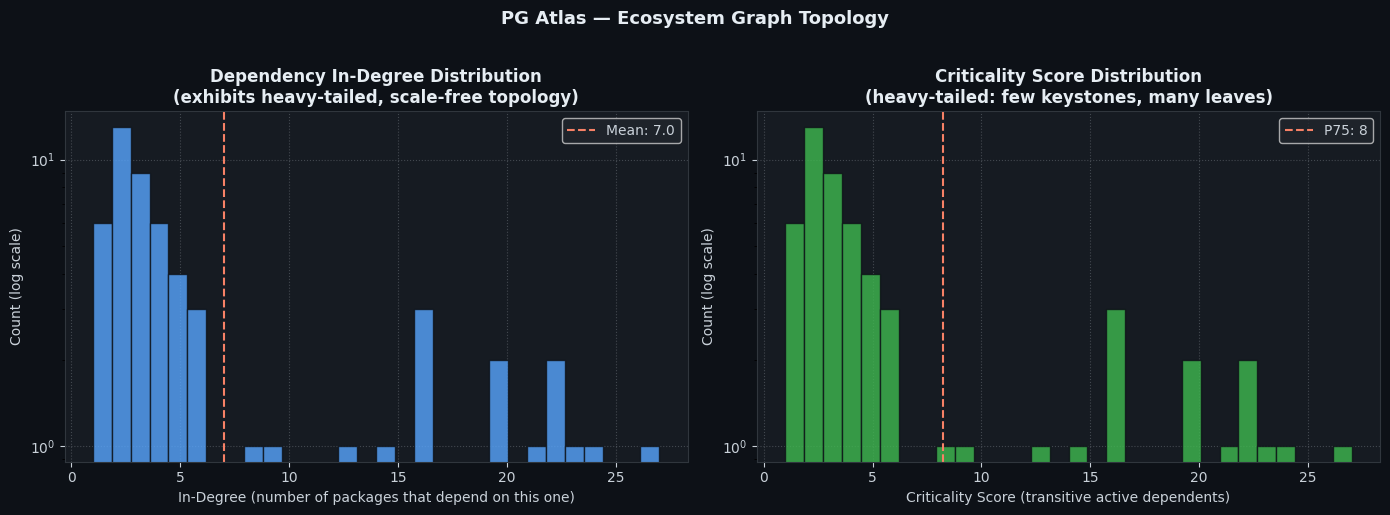

✅ Figure 1 saved


In [50]:
# ── Figure 1: Degree Distribution (confirms power-law) ───────────────────────

dep_subgraph_nodes = {n for n,d in G_active.nodes(data=True) 
                      if d.get('node_type') in ('Repo','ExternalRepo')}
dep_subgraph = G_active.subgraph(dep_subgraph_nodes)

in_degrees  = [d for _, d in dep_subgraph.in_degree()]
out_degrees = [d for _, d in dep_subgraph.out_degree()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0d1117')

for ax in axes:
    ax.set_facecolor('#161b22')
    ax.tick_params(colors='#c9d1d9')
    ax.xaxis.label.set_color('#c9d1d9')
    ax.yaxis.label.set_color('#c9d1d9')
    ax.title.set_color('#e6edf3')
    for spine in ax.spines.values():
        spine.set_edgecolor('#30363d')
    ax.grid(True, linestyle=':', alpha=0.25, color='#c9d1d9', zorder=0)
    ax.set_axisbelow(True)

# In-degree histogram (how many packages depend on each package)
non_zero_in = [d for d in in_degrees if d > 0]
axes[0].hist(non_zero_in, bins=30, color='#58a6ff', edgecolor='#0d1117', alpha=0.8, log=True)
axes[0].set_xlabel('In-Degree (number of packages that depend on this one)')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('Dependency In-Degree Distribution\n(exhibits heavy-tailed, scale-free topology)', fontweight='bold')
axes[0].axvline(np.mean(non_zero_in), color='#f78166', linestyle='--', 
                label=f'Mean: {np.mean(non_zero_in):.1f}')
axes[0].legend(facecolor='#21262d', labelcolor='#c9d1d9')

# Criticality score histogram
crit_vals = [v for v in criticality_scores.values() if v > 0]
axes[1].hist(crit_vals, bins=30, color='#3fb950', edgecolor='#0d1117', alpha=0.8, log=True)
axes[1].set_xlabel('Criticality Score (transitive active dependents)')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_title('Criticality Score Distribution\n(heavy-tailed: few keystones, many leaves)', fontweight='bold')
axes[1].axvline(np.percentile(crit_vals, 75) if crit_vals else 0, 
                color='#f78166', linestyle='--', 
                label=f'P75: {np.percentile(crit_vals, 75):.0f}' if crit_vals else '')
axes[1].legend(facecolor='#21262d', labelcolor='#c9d1d9')

plt.suptitle('PG Atlas — Ecosystem Graph Topology', color='#e6edf3', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig1_degree_distribution.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117')
plt.show()
print("✅ Figure 1 saved")

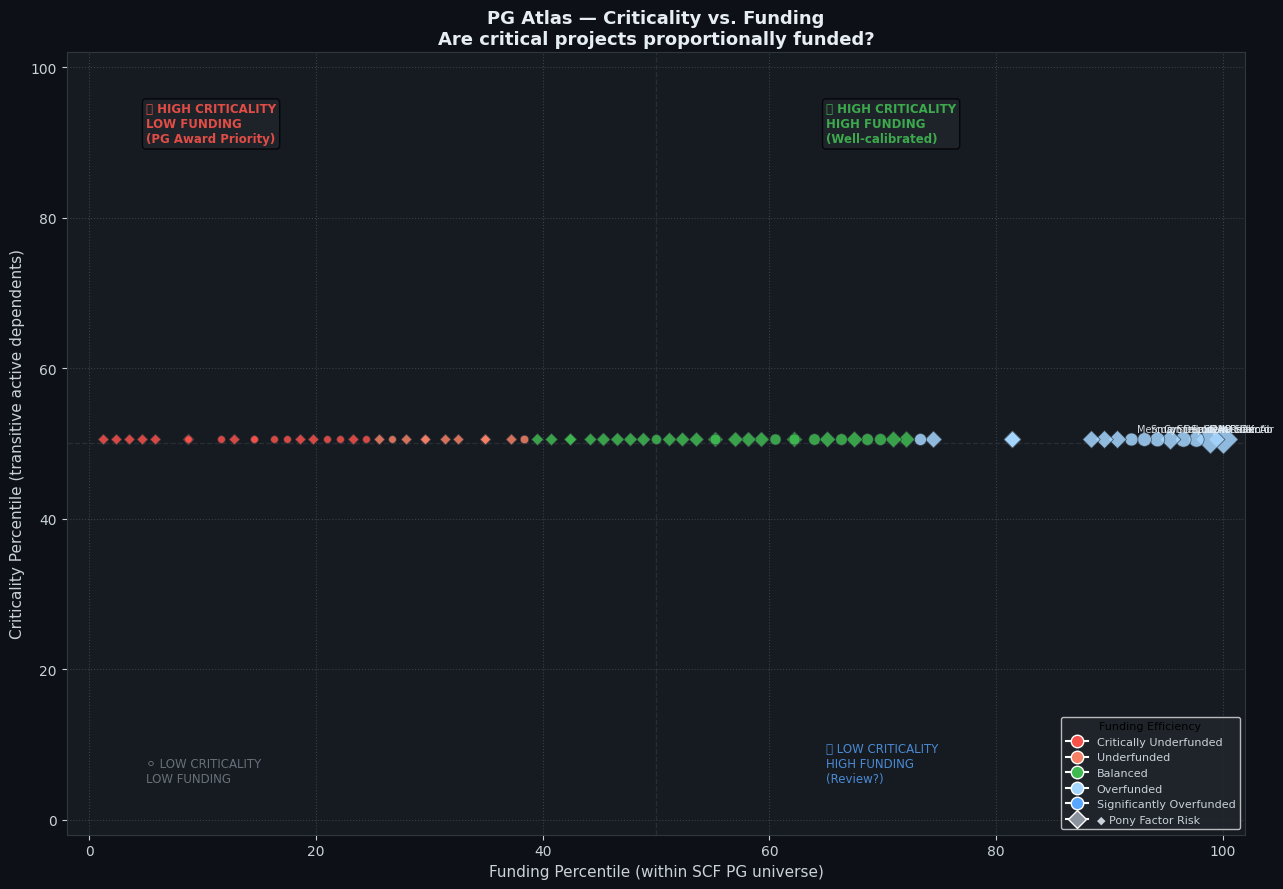

✅ Figure 2 saved — the governance diagnostic


In [51]:
# ── Figure 2: Criticality vs Funding (the key governance scatter) ─────────────

fig, ax = plt.subplots(figsize=(13, 9))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#161b22')
ax.grid(True, linestyle=':', alpha=0.2, color='#c9d1d9', zorder=0)
ax.set_axisbelow(True)

tier_colors = {
    'critically_underfunded': '#f85149',
    'underfunded': '#f78166',
    'balanced': '#3fb950',
    'overfunded': '#a5d6ff',
    'significantly_overfunded': '#58a6ff',
    'unknown': '#8b949e',
}

for _, row in df_scores.iterrows():
    color = tier_colors.get(row['fer_tier'], '#8b949e')
    size  = max(30, min(300, row['funding'] / 2000))
    marker = 'D' if row['pony_flag'] else 'o'
    alpha = 0.85
    ax.scatter(row['funding_pct'], row['criticality_pct'], 
               c=color, s=size, marker=marker, alpha=alpha, zorder=3,
               edgecolors='#30363d', linewidth=0.5)

# Quadrant lines
ax.axhline(50, color='#30363d', linewidth=1, linestyle='--', alpha=0.7)
ax.axvline(50, color='#30363d', linewidth=1, linestyle='--', alpha=0.7)

# Quadrant labels
ax.text(5, 90, '🔴 HIGH CRITICALITY\nLOW FUNDING\n(PG Award Priority)', 
        color='#f85149', fontsize=8.5, fontweight='bold', alpha=0.9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#21262d', alpha=0.8))
ax.text(65, 90, '✅ HIGH CRITICALITY\nHIGH FUNDING\n(Well-calibrated)', 
        color='#3fb950', fontsize=8.5, fontweight='bold', alpha=0.9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#21262d', alpha=0.8))
ax.text(5, 5, '⚪ LOW CRITICALITY\nLOW FUNDING', 
        color='#8b949e', fontsize=8.5, alpha=0.7)
ax.text(65, 5, '🔵 LOW CRITICALITY\nHIGH FUNDING\n(Review?)', 
        color='#58a6ff', fontsize=8.5, alpha=0.8)

# Label top critical projects
top_critical = df_scores.nlargest(8, 'criticality_pct')
for _, row in top_critical.iterrows():
    ax.annotate(row['project'][:20], 
                xy=(row['funding_pct'], row['criticality_pct']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=7, color='#e6edf3', alpha=0.9)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=9, label=t.replace('_', ' ').title())
    for t, c in tier_colors.items() if t != 'unknown'
] + [
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#8b949e', markersize=9, 
           label='◆ Pony Factor Risk'),
]
ax.legend(handles=legend_elements, loc='lower right', 
          facecolor='#21262d', labelcolor='#c9d1d9', fontsize=8,
          title='Funding Efficiency', title_fontsize=8,
          framealpha=0.9)

ax.set_xlabel('Funding Percentile (within SCF PG universe)', color='#c9d1d9', fontsize=11)
ax.set_ylabel('Criticality Percentile (transitive active dependents)', color='#c9d1d9', fontsize=11)
ax.set_title('PG Atlas — Criticality vs. Funding\nAre critical projects proportionally funded?',
             color='#e6edf3', fontsize=13, fontweight='bold')
ax.tick_params(colors='#c9d1d9')
for spine in ax.spines.values():
    spine.set_edgecolor('#30363d')
ax.set_xlim(-2, 102)
ax.set_ylim(-2, 102)

plt.tight_layout()
plt.savefig('fig2_criticality_vs_funding.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117')
plt.show()
print("✅ Figure 2 saved — the governance diagnostic")

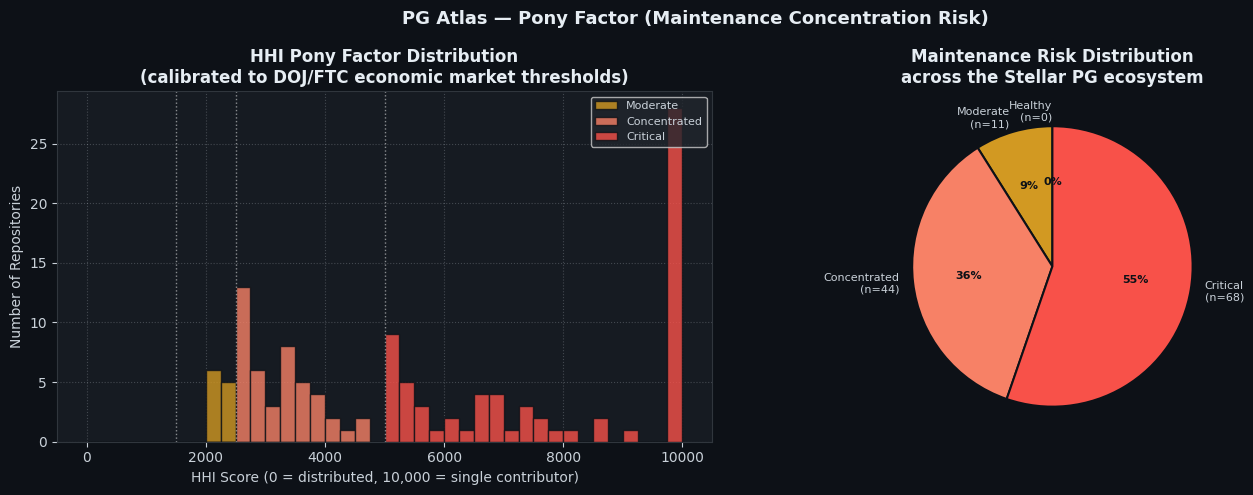

✅ Figure 3 saved


In [52]:
# ── Figure 3: Pony Factor HHI Distribution ────────────────────────────────────

hhi_vals = [r.hhi for r in pony_results.values()]
tiers     = [r.risk_tier for r in pony_results.values()]

tier_order  = ['healthy', 'moderate', 'concentrated', 'critical']
tier_colors_pf = {
    'healthy': '#3fb950',
    'moderate': '#d29922',
    'concentrated': '#f78166',
    'critical': '#f85149',
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0d1117')

for ax in axes:
    ax.set_facecolor('#161b22')
    ax.tick_params(colors='#c9d1d9')
    ax.xaxis.label.set_color('#c9d1d9')
    ax.yaxis.label.set_color('#c9d1d9')
    ax.title.set_color('#e6edf3')
    for spine in ax.spines.values():
        spine.set_edgecolor('#30363d')

axes[0].grid(True, linestyle=':', alpha=0.25, color='#c9d1d9', zorder=0)
axes[0].set_axisbelow(True)

# HHI histogram coloured by tier
bins = np.linspace(0, 10000, 41)
for tier in tier_order:
    vals = [h for h, t in zip(hhi_vals, tiers) if t == tier]
    if vals:
        axes[0].hist(vals, bins=bins, color=tier_colors_pf[tier], 
                     alpha=0.8, label=tier.replace('_', ' ').title(), edgecolor='#0d1117')

axes[0].axvline(1500, color='white', linestyle=':', alpha=0.5, linewidth=1)
axes[0].axvline(2500, color='white', linestyle=':', alpha=0.5, linewidth=1)
axes[0].axvline(5000, color='white', linestyle=':', alpha=0.5, linewidth=1)
axes[0].set_xlabel('HHI Score (0 = distributed, 10,000 = single contributor)')
axes[0].set_ylabel('Number of Repositories')
axes[0].set_title('HHI Pony Factor Distribution\n(calibrated to DOJ/FTC economic market thresholds)', fontweight='bold')
axes[0].legend(facecolor='#21262d', labelcolor='#c9d1d9', fontsize=8)

# Pie chart by tier
tier_counts = Counter(tiers)
pie_vals    = [tier_counts.get(t, 0) for t in tier_order]
pie_colors  = [tier_colors_pf[t] for t in tier_order]
pie_labels  = [f"{t.replace('_',' ').title()}\n(n={tier_counts.get(t,0)})" for t in tier_order]

wedges, texts, autotexts = axes[1].pie(
    pie_vals, labels=pie_labels, colors=pie_colors,
    autopct='%1.0f%%', startangle=90,
    textprops={'color': '#c9d1d9', 'fontsize': 8},
    wedgeprops={'edgecolor': '#0d1117', 'linewidth': 1.5},
)
for at in autotexts:
    at.set_color('#0d1117')
    at.set_fontweight('bold')

axes[1].set_title('Maintenance Risk Distribution\nacross the Stellar PG ecosystem', fontweight='bold')

plt.suptitle('PG Atlas — Pony Factor (Maintenance Concentration Risk)', 
             color='#e6edf3', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig3_pony_factor.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()
print("✅ Figure 3 saved")

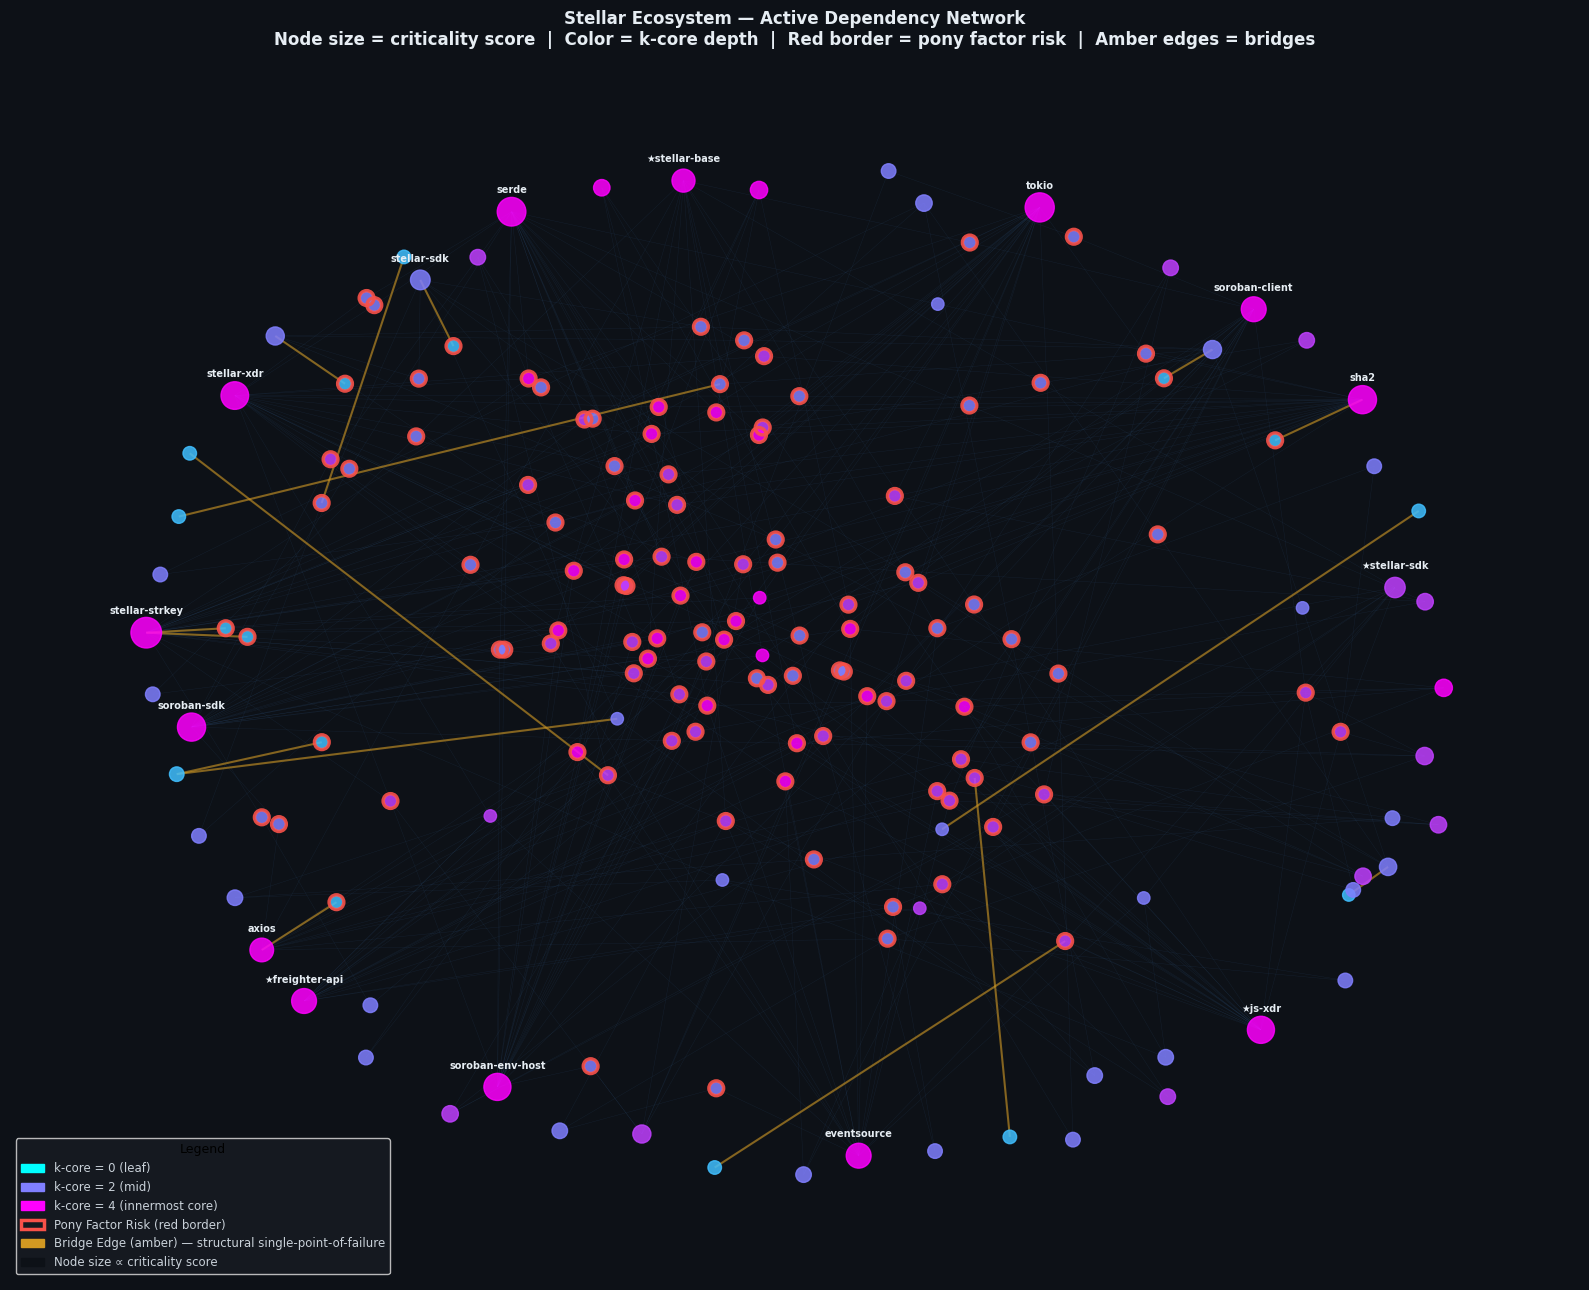

✅ Figure 4 saved — the ecosystem map


In [53]:
# ── Figure 4: Dependency Network Map (force-directed) ────────────────────────
# Show Repo + ExternalRepo nodes only; size by criticality; colour by k-core

# First, get all potential dependency nodes
all_dep_nodes = {n for n, d in G_active.nodes(data=True) 
                 if d.get('node_type') in ('Repo', 'ExternalRepo')}

# Build initial viz subgraph to find edges
G_viz_full = G_active.subgraph(all_dep_nodes)
dep_edges_viz = [(u,v) for u,v,d in G_viz_full.edges(data=True) if d.get('edge_type')=='depends_on']

# We want to show nodes that are either depended UPON (criticality > 0)
# OR nodes that DEPEND ON something (they are the source of a depends_on edge)
nodes_with_edges = set()
for u, v in dep_edges_viz:
    nodes_with_edges.add(u)
    nodes_with_edges.add(v)

# Also include high-profile hubs even if isolated in this synthetic graph
for n in all_dep_nodes:
    if G_active.nodes[n].get('is_hub') or criticality_scores.get(n, 0) > 0:
        nodes_with_edges.add(n)

dep_nodes_viz = nodes_with_edges

G_viz_simple = nx.DiGraph()
G_viz_simple.add_nodes_from(dep_nodes_viz)
G_viz_simple.add_edges_from([e for e in dep_edges_viz if e[0] in dep_nodes_viz and e[1] in dep_nodes_viz])

# Layout: use spring layout seeded with hub nodes at centre
pos = nx.spring_layout(G_viz_simple, k=2.5/np.sqrt(max(1, len(dep_nodes_viz))), 
                        seed=SEED, iterations=100)

fig, ax = plt.subplots(figsize=(16, 13))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#0d1117')
ax.set_axis_off()

# Node properties
core_nums = {n: G_active.nodes[n].get('core_number', 0) for n in dep_nodes_viz}
max_c = max(core_nums.values()) if core_nums else 1

# Color by core number (blues: outer → cyan/white: inner)
cmap = plt.cm.cool
node_colors = [cmap(core_nums.get(n, 0) / max(max_c, 1)) for n in G_viz_simple.nodes()]

# Size by criticality (log-scaled, hub nodes are large)
node_sizes = [
    max(30, min(1200, 80 + criticality_scores.get(n, 0) * 15))
    for n in G_viz_simple.nodes()
]

# Draw edges (faint)
nx.draw_networkx_edges(G_viz_simple, pos, ax=ax, alpha=0.10, 
                        edge_color='#58a6ff', arrows=False, width=0.3)

# Highlight bridge edges
bridge_set = set((u,v) for u,v in bridges) | set((v,u) for u,v in bridges)
bridge_edges_in_viz = [(u,v) for u,v in G_viz_simple.edges() 
                        if (u,v) in bridge_set or (v,u) in bridge_set]
if bridge_edges_in_viz:
    nx.draw_networkx_edges(G_viz_simple, pos, edgelist=bridge_edges_in_viz, ax=ax,
                           alpha=0.6, edge_color='#d29922', arrows=False, width=1.5)

# Draw nodes
nx.draw_networkx_nodes(G_viz_simple, pos, ax=ax,
                        node_color=node_colors, node_size=node_sizes,
                        alpha=0.85)

# Label top 15 nodes by criticality
top_nodes = sorted(
    [(n, criticality_scores.get(n, 0)) for n in G_viz_simple.nodes()],
    key=lambda x: x[1], reverse=True
)[:15]

label_pos = {n: (pos[n][0], pos[n][1] + 0.04) for n, _ in top_nodes if n in pos}
labels = {n: n.replace('repo:', '').replace('@stellar/', '★').replace('-npm-0','').replace('-cargo-0','') 
          for n, _ in top_nodes}
nx.draw_networkx_labels(G_viz_simple, label_pos, labels=labels, ax=ax,
                         font_size=7, font_color='#e6edf3', font_weight='bold')

# Add pony factor border for high-risk nodes
pony_nodes_viz = [n for n in G_viz_simple.nodes() if 
                  pony_results.get(n, None) is not None and 
                  pony_results[n].risk_tier in ('critical', 'concentrated')]
if pony_nodes_viz:
    nx.draw_networkx_nodes(G_viz_simple, pos, nodelist=pony_nodes_viz, ax=ax,
                           node_size=[node_sizes[list(G_viz_simple.nodes()).index(n)] * 1.4 
                                      for n in pony_nodes_viz],
                           node_color='none', edgecolors='#f85149', linewidths=2.5, alpha=0.9)

# Legend
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color=cmap(0.0), label=f'k-core = 0 (leaf)'),
    mpatches.Patch(color=cmap(0.5), label=f'k-core = {max_c//2} (mid)'),
    mpatches.Patch(color=cmap(1.0), label=f'k-core = {max_c} (innermost core)'),
    mpatches.Patch(facecolor='none', edgecolor='#f85149', linewidth=2.5, label='Pony Factor Risk (red border)'),
    mpatches.Patch(color='#d29922', label='Bridge Edge (amber) — structural single-point-of-failure'),
    mpatches.Patch(color='#0d1117', label='Node size ∝ criticality score'),
]
ax.legend(handles=legend_elements, loc='lower left', facecolor='#161b22',
          labelcolor='#c9d1d9', fontsize=8.5, framealpha=0.9,
          title='Legend', title_fontsize=9)

ax.set_title(
    'Stellar Ecosystem — Active Dependency Network\n'
    'Node size = criticality score  |  Color = k-core depth  |  '
    'Red border = pony factor risk  |  Amber edges = bridges',
    color='#e6edf3', fontsize=12, fontweight='bold', pad=15
)

plt.tight_layout()
plt.savefig('fig4_dependency_network.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()
print("✅ Figure 4 saved — the ecosystem map")

## 12. Algorithm Summary & Production Readiness

This notebook prototyped all core PG Atlas graph algorithms on a realistic synthetic graph.
Here is the production readiness status of each algorithm:

In [54]:
# ── Final Consolidated Report ────────────────────────────────────────────────

print("╔══════════════════════════════════════════════════════════════════════════╗")
print("║  PG ATLAS — ALGORITHM PROTOTYPE REPORT                                  ║")
print("╠══════════════════════════════════════════════════════════════════════════╣")
print()

print("  GRAPH STATISTICS")
print(f"    Nodes (full):           {G.number_of_nodes():>6}")
print(f"    Nodes (active):         {G_active.number_of_nodes():>6}  ({G_active.number_of_nodes()/G.number_of_nodes()*100:.1f}% retained)")
print(f"    Edges (full):           {G.number_of_edges():>6}")
print(f"    Edges (active):         {G_active.number_of_edges():>6}  ({G_active.number_of_edges()/G.number_of_edges()*100:.1f}% retained)")
print(f"    Max k-core:             {max_core:>6}")
print(f"    Bridge edges:           {len(bridges):>6}")
print()

print("  A6 — ACTIVE SUBGRAPH PROJECTION")
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Dormant nodes pruned:   {dormant_count:>6}")
print(f"    Algorithm:              Vertex filter + induced subgraph")
print(f"    Production path:        Translate to pg_atlas.graph.active_subgraph()")
print()

print("  A9 — CRITICALITY SCORE")
total_scored = sum(1 for v in criticality_scores.values() if v > 0)
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Nodes scored (> 0):     {total_scored:>6}")
print(f"    Max criticality:        {max(criticality_scores.values()):>6}")
print(f"    Algorithm:              BFS on reversed active dependency graph")
print(f"    Extension:              Temporal decay weighting (Tier 2, implemented)")
print()

print("  A9 — PONY FACTOR")
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Repos with PF=1:        {pony_flagged:>6}  ({pony_flagged/total_repos_with_pf*100:.0f}% of repos)")
print(f"    Critical HHI (>5000):   {risk_dist.get('critical',0):>6}")
print(f"    Algorithm:              HHI over contributor commit shares (Tier 2 bonus)")
print()

print("  A10 — ADOPTION SIGNALS")
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Nodes scored:           {len(adoption_scores):>6}")
print(f"    Algorithm:              Log-scale normalization of stars, forks, downloads")
print()

print("  K-CORE DECOMPOSITION (Tier 2)")
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Max core number:        {max_core:>6}")
print(f"    Inner core size:        {sum(1 for k in core_numbers.values() if k == max_core):>6}")
print(f"    Algorithm:              networkx.core_number() (Matula & Beck, 1983)")
print()

print("  BRIDGE DETECTION (Tier 2)")
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Bridges found:          {len(bridges):>6}")
print(f"    Algorithm:              Tarjan's algorithm via networkx.bridges()")
print()

print("  FUNDING EFFICIENCY RATIO (Tier 3)")
underfunded_n = len(df_scores[df_scores['fer_tier'].isin(['critically_underfunded','underfunded'])])
print(f"    Status: ✅ PROTOTYPE COMPLETE")
print(f"    Underfunded critical:   {underfunded_n:>6}")
print(f"    Algorithm:              Percentile ratio (criticality / funding)")
print()

print("╠══════════════════════════════════════════════════════════════════════════╣")
print("║  NEXT STEPS                                                              ║")
print("╠══════════════════════════════════════════════════════════════════════════╣")
print("║  1. Align with Alex Olieman on PostgreSQL schema (D5 interface contract) ║")
print("║  2. Translate NetworkX graph construction from schema → pg_atlas.graph  ║")
print("║  3. Run A7 git log parser on real repos (338 in A7_submission_repos.csv) ║")
print("║  4. Replace synthetic activity signals with real deps.dev OpenSSF data  ║")
print("║  5. Calibrate metric thresholds against known reference projects         ║")
print("║  6. Propose k-core + funding efficiency ratio as v0 scope additions      ║")
print("╚══════════════════════════════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════════════════════════════╗
║  PG ATLAS — ALGORITHM PROTOTYPE REPORT                                  ║
╠══════════════════════════════════════════════════════════════════════════╣

  GRAPH STATISTICS
    Nodes (full):              423
    Nodes (active):            383  (90.5% retained)
    Edges (full):             1050
    Edges (active):            851  (81.0% retained)
    Max k-core:                  4
    Bridge edges:               16

  A6 — ACTIVE SUBGRAPH PROJECTION
    Status: ✅ PROTOTYPE COMPLETE
    Dormant nodes pruned:       40
    Algorithm:              Vertex filter + induced subgraph
    Production path:        Translate to pg_atlas.graph.active_subgraph()

  A9 — CRITICALITY SCORE
    Status: ✅ PROTOTYPE COMPLETE
    Nodes scored (> 0):         56
    Max criticality:            27
    Algorithm:              BFS on reversed active dependency graph
    Extension:              Temporal decay weighting (Tier 2, impleme

---

## Appendix: Production Implementation Notes

### Graph Construction from PostgreSQL (D5)

When Alex's schema is locked, the NetworkX graph construction layer will follow this pattern:

```python
import networkx as nx
import psycopg2

def build_graph_from_db(conn) -> nx.DiGraph:
    G = nx.DiGraph()
    cur = conn.cursor()

    # Load Repo vertices
    cur.execute("SELECT id, project_id, ecosystem, latest_commit_date FROM repo")
    for row in cur.fetchall():
        G.add_node(row[0], node_type='Repo', project=row[1], 
                   ecosystem=row[2], latest_commit_date=row[3])

    # Load dependency edges
    cur.execute("SELECT from_repo, to_repo, confidence FROM depends_on")
    for u, v, conf in cur.fetchall():
        G.add_edge(u, v, edge_type='depends_on', confidence=conf)

    # Load contributor edges
    cur.execute("SELECT contributor_id, repo_id, commits FROM contributed_to")
    for c, r, n in cur.fetchall():
        G.add_edge(c, r, edge_type='contributed_to', commits=n)

    return G
```

### API Endpoints (D7)

```python
# FastAPI sketch — analytics endpoints Jay owns
@app.get("/scores/{package_id}")
def get_scores(package_id: str):
    return {
        "criticality_score": criticality_scores.get(package_id),
        "criticality_percentile": percentiles.get(package_id),
        "pony_factor": pony_results.get(package_id).pony_factor if package_id in pony_results else None,
        "hhi": pony_results.get(package_id).hhi if package_id in pony_results else None,
        "k_core": G_active.nodes.get(package_id, {}).get('core_number'),
    }

@app.get("/dependents/{package_id}")
def get_dependents(package_id: str, transitive: bool = False):
    if transitive:
        return {"dependents": list(nx.descendants(G_rev, package_id))}
    return {"dependents": list(G_active.predecessors(package_id))}
```

---

*Notebook authored February 2026 — Jay Gutierrez, PhD*  
*SCF #41 — Building the Backbone: PG Atlas*  
*Contact: jg@graphoflife.com*